In [2]:
!ls provided_material/german-traffic-signs

signnames.csv  test.p  train.p	valid.p


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import keras
import random

from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from keras.utils.np_utils import to_categorical
from keras.layers import Dropout, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D

import pickle
import pandas as pd

In [4]:
np.random.seed(0)

In [5]:
with open("provided_material/german-traffic-signs/train.p", 'rb') as f:
    train_data = pickle.load(f)
with open("provided_material/german-traffic-signs/valid.p", 'rb') as f:
    val_data = pickle.load(f)
with open("provided_material/german-traffic-signs/test.p", 'rb') as f:
    test_data = pickle.load(f)

print ( "type(train_data) = ", type(train_data) )
print ( "type(val_data) = ", type(val_data) )
print ( "type(test_data) = ", type(test_data) )

type(train_data) =  <class 'dict'>
type(val_data) =  <class 'dict'>
type(test_data) =  <class 'dict'>


In [6]:
X_train, y_train = train_data [ 'features'], train_data[ 'labels' ]
X_val, y_val = val_data [ 'features'], val_data[ 'labels' ]
X_test, y_test = test_data [ 'features'], test_data[ 'labels' ]

print ( "X_train.shape = ", X_train.shape, "\t\ty_train.shape = ", y_train.shape)
print ( "X_val.shape = ", X_val.shape, "\t\ty_val.shape = ", y_val.shape)
print ( "X_test.shape = ", X_test.shape, "\t\ty_test.shape = ", y_test.shape)

X_train.shape =  (34799, 32, 32, 3) 		y_train.shape =  (34799,)
X_val.shape =  (4410, 32, 32, 3) 		y_val.shape =  (4410,)
X_test.shape =  (12630, 32, 32, 3) 		y_test.shape =  (12630,)


In [7]:
assert( X_train.shape[ 0 ] == y_train.shape[ 0 ]), "Training data: #images != #labels"
assert( X_val.shape[ 0 ] == y_val.shape[ 0 ]), "Training data: #images != #labels"
assert( X_test.shape[ 0 ] == y_test.shape[ 0 ]), "Testing data: #images != #labels"
assert( X_train.shape[ 1: ] == ( 32, 32, 3 ) ), "The dimensions of the images have to be 32x32."
assert( X_val.shape[ 1: ] == ( 32, 32, 3 ) ), "The dimensions of the images have to be 32x32."
assert( X_test.shape[ 1: ] == ( 32, 32, 3 ) ), "The dimensions of the images have to be 32x32."

In [8]:
data = pd.read_csv('provided_material/german-traffic-signs/signnames.csv')

In [9]:
print(data.shape[0])
print(data)

43
    ClassId                                           SignName
0         0                               Speed limit (20km/h)
1         1                               Speed limit (30km/h)
2         2                               Speed limit (50km/h)
3         3                               Speed limit (60km/h)
4         4                               Speed limit (70km/h)
5         5                               Speed limit (80km/h)
6         6                        End of speed limit (80km/h)
7         7                              Speed limit (100km/h)
8         8                              Speed limit (120km/h)
9         9                                         No passing
10       10       No passing for vechiles over 3.5 metric tons
11       11              Right-of-way at the next intersection
12       12                                      Priority road
13       13                                              Yield
14       14                                         

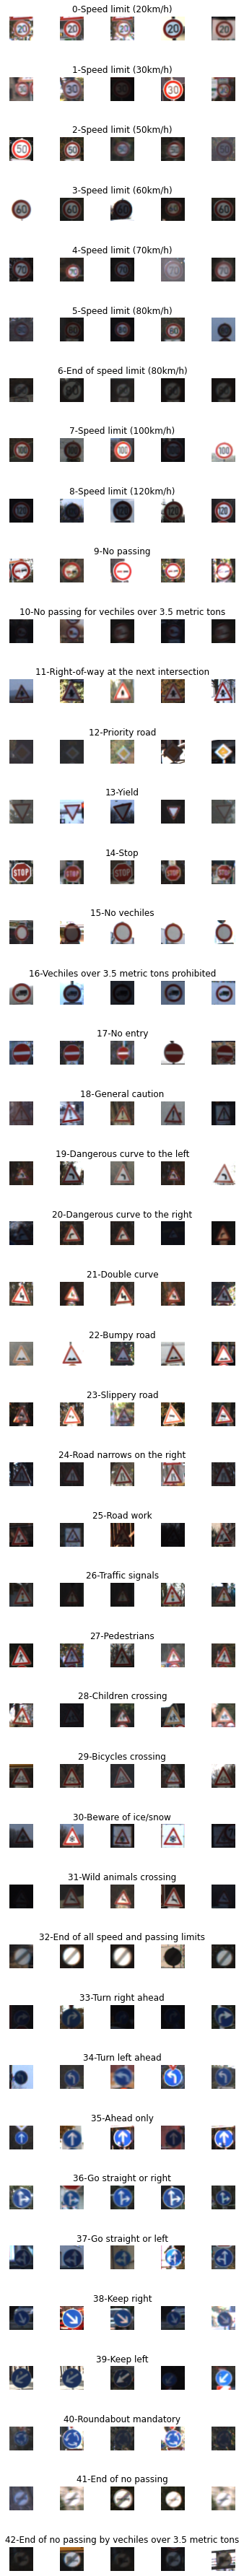

In [10]:
num_of_samples=[]

cols = 5
num_classes = data.shape [ 0 ]

fig, axs = plt.subplots( nrows=num_classes, ncols=cols, figsize = ( 5, 50 ) )
fig.tight_layout()

for i in range( cols ):
    for j, row in data.iterrows():
        x_selected = X_train[ y_train == j ]
        axs[ j ][ i ].imshow(x_selected[ random.randint( 0, ( len( x_selected ) - 1 ) ), :, :], cmap = plt.get_cmap('gray'))
        axs[ j ][ i ].axis( "off" )
        if i == 2:
            axs[ j ][ i ].set_title( str( j ) + "-" + row[ "SignName" ] )
            num_of_samples.append( len( x_selected ) )
    #(index, Series)

[180, 1980, 2010, 1260, 1770, 1650, 360, 1290, 1260, 1320, 1800, 1170, 1890, 1920, 690, 540, 360, 990, 1080, 180, 300, 270, 330, 450, 240, 1350, 540, 210, 480, 240, 390, 690, 210, 599, 360, 1080, 330, 180, 1860, 270, 300, 210, 210]


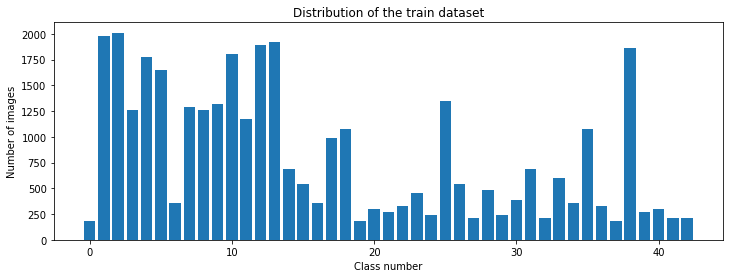

In [11]:
print(num_of_samples)
plt.figure(figsize=(12, 4))
plt.bar(range(0, num_classes), num_of_samples)
plt.title("Distribution of the train dataset")
plt.xlabel("Class number")
plt.ylabel("Number of images")
plt.show()

(32, 32, 3)
36
Go straight or right


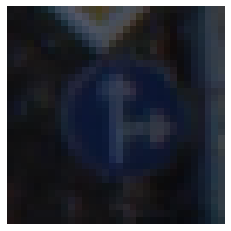

In [12]:
# a block to do some spot checks on input data:
# can the image be displayed, is the class assigned correctly
import cv2
img_index = 1000
plt.imshow( X_train [ img_index ] )
plt.axis( "off" )

img_class = y_train[ img_index ]
print ( X_train[ img_index ].shape )
print ( img_class )

print ( data.at[ img_class, 'SignName' ] )

In [13]:
def grayscale( img ):
    img_gray = cv2.cvtColor( img, cv2.COLOR_BGR2GRAY)
    return img_gray

(32, 32)


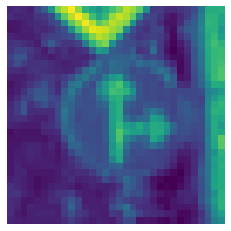

In [14]:
img_gray_test = grayscale( X_train [ img_index ] )
plt.imshow( img_gray_test )
plt.axis( "off" )
print( img_gray_test.shape )

In [15]:
# normalize the image, such that darkest color = 0.0, brightest level = 1.0
def equalize( img ):
    img_norm = cv2.equalizeHist( img )
    return img_norm

(32, 32)


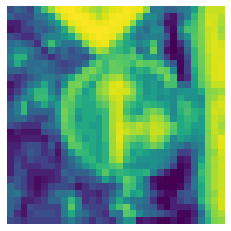

In [16]:
img_norm = equalize( img_gray_test )
plt.imshow( img_norm )
plt.axis( "off" )
print( img_norm.shape )

In [17]:
def preprocessing( img ):
    img = grayscale ( img )
    img = equalize ( img )
    img = img / 255
    return img

In [18]:
X_train_pp = np.array( list ( map( preprocessing, X_train ) ) )
X_val_pp = np.array( list ( map( preprocessing, X_val ) ) )
X_test_pp = np.array( list ( map( preprocessing, X_test ) ) )

#y_train_pp = np.array( list ( map( preprocessing, y_train ) ) )
#y_val_pp = np.array( list ( map( preprocessing, y_val ) ) )
#y_test_pp = np.array( list ( map( preprocessing, y_test ) ) )

X_train_pp.shape =  (34799, 32, 32)
X_val_pp.shape =  (4410, 32, 32)
X_test_pp.shape =  (12630, 32, 32)


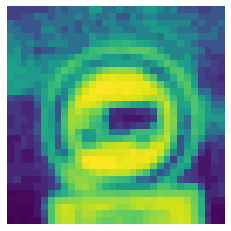

In [19]:
plt.imshow( X_train_pp [ random.randint( 0, ( len( X_train_pp ) - 1 ) ) ])
plt.axis( "off" )
print ( "X_train_pp.shape = ", X_train_pp.shape )
print ( "X_val_pp.shape = ", X_val_pp.shape )
print ( "X_test_pp.shape = ", X_test_pp.shape )

In [29]:
X_train_flat = X_train_pp.reshape( ( X_train_pp.shape[ 0 ], X_train_pp.shape[ 1 ], X_train_pp.shape[ 2 ], 1 ) )
X_val_flat = X_val_pp.reshape( ( X_val_pp.shape[ 0 ], X_val_pp.shape[ 1 ], X_val_pp.shape[ 2 ], 1 ) )
X_test_flat = X_test_pp.reshape( ( X_test_pp.shape[ 0 ], X_test_pp.shape[ 1 ], X_test_pp.shape[ 2 ], 1 ) )
print( X_train_flat.shape )
print( X_val_flat.shape )
print( X_test_flat.shape )

(34799, 32, 32, 1)
(4410, 32, 32, 1)
(12630, 32, 32, 1)


In [30]:
y_train_flat = to_categorical( y_train, num_classes )
y_val_flat = to_categorical( y_val, num_classes )
y_test_flat = to_categorical( y_test, num_classes )
print( y_train_flat.shape )
print( y_val_flat.shape )
print( y_test_flat.shape )

(34799, 43)
(4410, 43)
(12630, 43)


In [39]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(width_shift_range = 0.1,
                             height_shift_range = 0.1,
                             zoom_range = 0.2,
                             shear_range = 0.1,
                             rotation_range = 10)

datagen.fit( X_train_flat )

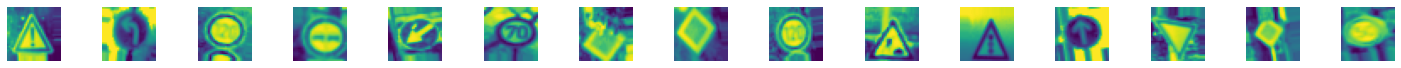

In [40]:
batches = datagen.flow( X_train_flat, y_train_flat, batch_size = 20 )
X_batch, y_batch = next( batches )
fig, axs = plt.subplots( 1, 15, figsize = ( 20, 5 ) )
fig.tight_layout()

for i in range( 15 ):
    axs[ i ].imshow( X_batch[ i ].reshape( 32, 32 ) )
    axs[ i ].axis( 'off' )

In [41]:
# define the larger model
def leNet_model():
    # create model
    model = Sequential()
    model.add( Conv2D(60, (5, 5), input_shape = ( X_train_flat.shape[ 1 ], X_train_flat.shape[ 2 ], X_train_flat.shape[ 3 ]), activation='relu' ) )
    model.add( Conv2D(60, (5, 5), activation='relu' ) )
    model.add( MaxPooling2D( pool_size = ( 2, 2 ) ) )

    model.add( Conv2D( 30, ( 3, 3 ), activation = 'relu' ) )
    model.add( Conv2D( 30, ( 3, 3 ), activation = 'relu' ) )
    model.add( MaxPooling2D( pool_size = ( 2, 2 ) ) )
    model.add( Dropout( 0.5 ) )

    model.add( Flatten ( ) )
    model.add( Dense( 500, activation = 'relu' ) )
    model.add( Dropout( 0.5 ) )
    model.add( Dense( num_classes, activation = 'softmax' ) )
    # Compile model
    model.compile( Adam( lr = 0.001 ), loss = 'categorical_crossentropy', metrics = [ 'accuracy' ] )
    return model

In [42]:
model = leNet_model()
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 28, 28, 60)        1560      
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 24, 24, 60)        90060     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 12, 12, 60)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 10, 10, 30)        16230     
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 8, 8, 30)          8130      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 4, 4, 30)          0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 4, 4, 30)         

In [46]:
# no fit generator
#history = model.fit( X_train_flat, y_train_flat, epochs = 10,  validation_data = ( X_val_flat, y_val_flat), batch_size = 400, verbose = 1, shuffle = 1)

BATCH_SIZE = 64
BUFFER_SIZE = 10000

#ImageDataGenerator
datagen2 = datagen

# use fit generator
history = model.fit( datagen2.flow( X_train_flat, y_train_flat, batch_size = 20 ), steps_per_epoch = len( X_train_flat ) / 20, epochs = 10,  validation_data = ( X_val_flat, y_val_flat), verbose = 1, shuffle = 1)

#model.fit_generator(
#    train_generator,
#    steps_per_epoch = datagen2.samples/train_generator.batch_size,
#    epochs=10,
#    validation_data=validation_generator,
#    validation_steps=validation_generator.samples/validation_generator.batch_size)

Epoch 1/10
1740/1739 [==============================] - 69s 40ms/step - loss: 0.4953 - accuracy: 0.8443 - val_loss: 0.0843 - val_accuracy: 0.9710
Epoch 2/10
1740/1739 [==============================] - 68s 39ms/step - loss: 0.3918 - accuracy: 0.8781 - val_loss: 0.0886 - val_accuracy: 0.9696
Epoch 3/10
1740/1739 [==============================] - 72s 41ms/step - loss: 0.3509 - accuracy: 0.8946 - val_loss: 0.0480 - val_accuracy: 0.9855
Epoch 4/10
1740/1739 [==============================] - 70s 40ms/step - loss: 0.3106 - accuracy: 0.9055 - val_loss: 0.0430 - val_accuracy: 0.9884
Epoch 5/10
1740/1739 [==============================] - 70s 40ms/step - loss: 0.2856 - accuracy: 0.9133 - val_loss: 0.0418 - val_accuracy: 0.9855
Epoch 6/10
1740/1739 [==============================] - 72s 42ms/step - loss: 0.2620 - accuracy: 0.9197 - val_loss: 0.0688 - val_accuracy: 0.9787
Epoch 7/10
1740/1739 [==============================] - 67s 38ms/step - loss: 0.2461 - accuracy: 0.9241 - val_loss: 0.0474 -

Text(0.5, 0, 'epoch')

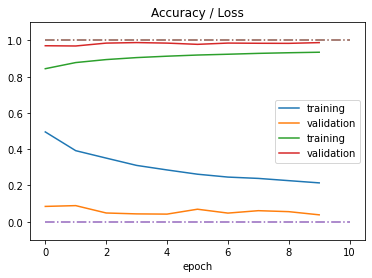

In [47]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.plot([0,10],[0,0],'-.')
plt.plot([0,10],[1,1],'-.')

plt.legend( ['training', 'validation', 'training','validation' ] )
plt.title('Accuracy / Loss')
plt.ylim( ymin = -0.1, ymax = 1.1)
plt.xlabel('epoch')

In [48]:
score = model.evaluate(X_test_flat, y_test_flat, verbose=0)
 
print( 'Test score:', score [ 0 ] )
print( 'Test accuracy:', score [ 1 ])

Test score: 0.10576611757278442
Test accuracy: 0.9706255197525024


In [49]:
#predict internet number
import requests
from PIL import Image
import cv2

def TestImage(url):
    r = requests.get( url, stream=True )
    img = Image.open( r.raw )
    plt.imshow( img, cmap = plt.get_cmap( 'gray' ) )


    img = np.asarray( img )
    img = cv2.resize( img, ( X_train_flat.shape[ 1 ], X_train_flat.shape[ 2 ] ), 1, 1, interpolation = cv2.INTER_LANCZOS4 )
    img = cv2.cvtColor( img, cv2.COLOR_BGR2GRAY )
    img = cv2.bitwise_not( img )
    plt.imshow(img, cmap=plt.get_cmap( 'gray' ) )

    img = img / 255
    img = img.reshape( 1, X_train_flat.shape[ 1 ], X_train_flat.shape[ 2 ], X_train_flat.shape[ 3 ] )
    print( img.shape )

    print ( img.shape )
    print ( model.predict_classes( img )[ 0 ] )
    print ( "predicted digit: " + data.at[ model.predict_classes( img )[ 0 ], 'SignName' ] )

urlList = [
        'https://c8.alamy.com/comp/G667W0/road-sign-speed-limit-30-kmh-zone-passau-bavaria-germany-G667W0.jpg',
        'https://c8.alamy.com/comp/A0RX23/cars-and-automobiles-must-turn-left-ahead-sign-A0RX23.jpg',
        'https://previews.123rf.com/images/bwylezich/bwylezich1608/bwylezich160800375/64914157-german-road-sign-slippery-road.jpg',
        'https://previews.123rf.com/images/pejo/pejo0907/pejo090700003/5155701-german-traffic-sign-no-205-give-way.jpg',
        'https://c8.alamy.com/comp/J2MRAJ/german-road-sign-bicycles-crossing-J2MRAJ.jpg'
    ]

(1, 32, 32, 1)
(1, 32, 32, 1)
Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
12
predicted digit: Priority road


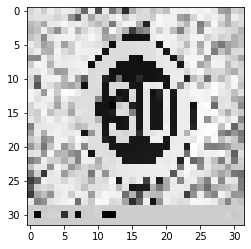

In [50]:
TestImage(urlList[0])

(1, 32, 32, 1)
(1, 32, 32, 1)
2
predicted digit: Speed limit (50km/h)


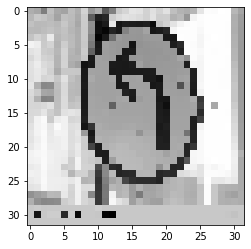

In [51]:
TestImage(urlList[1])

(1, 32, 32, 1)
(1, 32, 32, 1)
29
predicted digit: Bicycles crossing


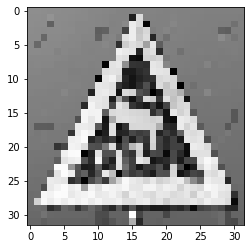

In [52]:
TestImage(urlList[2])

(1, 32, 32, 1)
(1, 32, 32, 1)
38
predicted digit: Keep right


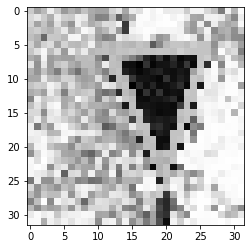

In [53]:
TestImage(urlList[3])

(1, 32, 32, 1)
(1, 32, 32, 1)
29
predicted digit: Bicycles crossing


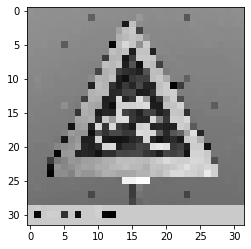

In [54]:
TestImage(urlList[4])

In [55]:
layer1 = Model(inputs=model.layers[0].input, outputs=model.layers[0].output)
layer2 = Model(inputs=model.layers[0].input, outputs=model.layers[2].output)

visual_layer1, visual_layer2 = layer1.predict(img), layer2.predict(img)

print(visual_layer1.shape)
print(visual_layer2.shape)

#layer 1
plt.figure(figsize=(10, 6))
for i in range(30):
    plt.subplot(6, 5, i+1)
    plt.imshow(visual_layer1[0, :, :, i], cmap=plt.get_cmap('jet'))
    plt.axis('off')

#layer 2
plt.figure(figsize=(10, 6))
for i in range(15):
    plt.subplot(3, 5, i+1)
    plt.imshow(visual_layer2[0, :, :, i], cmap=plt.get_cmap('jet'))
    plt.axis('off')

NameError: name 'Model' is not defined